<a href="https://colab.research.google.com/github/delemarchand2020/IVADO_MILA_DL/blob/main/Test_CLIP_Zero_Shot_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use CLIP Zero-Shot on your own classificaiton dataset

This notebook provides an example of how to benchmark CLIP's zero shot classification performance on your own classification dataset.

[CLIP](https://openai.com/blog/clip/) is a new zero shot image classifier relased by OpenAI that has been trained on 400 million text/image pairs across the web. CLIP uses these learnings to make predicts based on a flexible span of possible classification categories.

CLIP is zero shot, that means **no training is required**. 

Try it out on your own task here!

Be sure to experiment with various text prompts to unlock the richness of CLIP's pretraining procedure.

# Download and Install CLIP Dependencies

In [ ]:
#installing some dependencies, CLIP was release in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch
import os

print("Torch version:", torch.__version__)
os.kill(os.getpid(), 9)

In [1]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 90 (delta 0), reused 3 (delta 0), pack-reused 86
Unpacking objects: 100% (90/90), done.
/content/CLIP


# Download Classification Data or Object Detection Data

We will download the [public flowers classificaiton dataset](https://public.roboflow.com/classification/flowers_classification) from Roboflow. The data will come out as folders broken into train/valid/test splits and seperate folders for each class label.

You can easily download your own dataset from Roboflow in this format, too.

We made a conversion from object detection to CLIP text prompts in Roboflow, too, if you want to try that out.


To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
#download classification data
#replace with your link
!curl -L "https://public.roboflow.com/ds/voBptUkaY3?key=S51gBfZMC4" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [3]:
import os
#our the classes and images we want to test are stored in folders in the test set
class_names = os.listdir('./train/')
class_names.remove('_tokenization.txt')
class_names

['Tomato Cherry Red',
 'Tomato 4',
 'Tomato 3',
 'Walnut',
 'Tomato Maroon',
 'Tomato Yellow']

In [4]:
#we auto generate some example tokenizations in Roboflow but you should edit this file to try out your own prompts
#CLIP gets a lot better with the right prompting!
#be sure the tokenizations are in the same order as your class_names above!
%cat ./train/_tokenization.txt

An example picture from the Fruits Dataset dataset depicting a Tomato 3
An example picture from the Fruits Dataset dataset depicting a Tomato 4
An example picture from the Fruits Dataset dataset depicting a Tomato Cherry Red
An example picture from the Fruits Dataset dataset depicting a Tomato Maroon
An example picture from the Fruits Dataset dataset depicting a Tomato Yellow
An example picture from the Fruits Dataset dataset depicting a Walnut

In [5]:
#edit your prompts as you see fit here
%%writefile ./train/_tokenization.txt
Tomato Cherry Red
Tomato 3
Tomato 4
Walnut
Tomato Maroon
Tomato Yellow

Overwriting ./train/_tokenization.txt


In [6]:
candidate_captions = []
with open('./train/_tokenization.txt') as f:
    candidate_captions = f.read().splitlines()

In [7]:
print(candidate_captions)

['Tomato Cherry Red', 'Tomato 3', 'Tomato 4', 'Walnut', 'Tomato Maroon', 'Tomato Yellow']


# Run CLIP inference on your classification dataset

In [24]:
import torch
import clip
from PIL import Image
import glob

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
class_miss =[]

#define our target classificaitons, 
#you can should experiment with these strings of text as you see fit, 
#though, make sure they are in the same order as your class names above
text = clip.tokenize(candidate_captions).to(device)

for cls in class_names:
    class_correct = []
    test_imgs = glob.glob('./train/' + cls + '/*.jpg')
    for img in test_imgs:
        #print(img)
        image = transform(Image.open(img)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

            pred = class_names[argmax(list(probs)[0])]
            #print(pred)
            if pred == cls:
                correct.append(1)
                class_correct.append(1)
            else:
                correct.append(0)
                class_correct.append(0)
                class_miss.append([pred,cls])
    
    print('accuracy on class ' + cls + ' is :' + str(sum(class_correct)/len(class_correct)))
print('accuracy on all is : ' + str(sum(correct)/len(correct)))

accuracy on class Tomato Cherry Red is :0.8313008130081301
accuracy on class Tomato 4 is :0.0
accuracy on class Tomato 3 is :0.0
accuracy on class Walnut is :1.0
accuracy on class Tomato Maroon is :0.989100817438692
accuracy on class Tomato Yellow is :0.7625272331154684
accuracy on all is : 0.6383636988655895


1052
479


(array([  4.,   0.,  83.,   0.,   0., 479.,   0., 377.,   0., 109.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

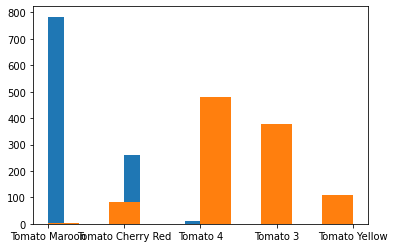

In [26]:
import numpy as np
import matplotlib.pyplot as plt
print(len(class_miss))
#print(class_miss)
misses = np.array(class_miss)
print(sum(misses[:,1] == 'Tomato 4'))
#np.histogram(misses.flatten)
plt.hist(misses[:,0])
plt.hist(misses[:,1])

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

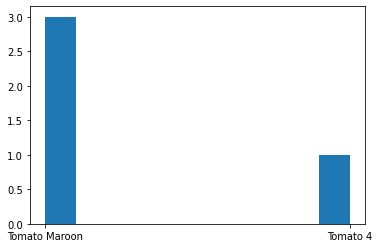

In [49]:
import numpy as np
import matplotlib.pyplot as plt

class_names = np.array(['Tomato Cherry Red',
 'Tomato 4',
 'Tomato 3',
 'Walnut',
 'Tomato Maroon',
 'Tomato Yellow'])

test = np.array([['Tomato Maroon', 'Tomato Cherry Red'],
 ['Tomato Maroon', 'Tomato Cherry Red'],
 ['Tomato Maroon', 'Tomato Cherry Red'],
 ['Tomato 4','Tomato Yellow']])

test_mapping = np.zeros(len(test))
for i in range(len(test)):
  id_class,  = np.where(class_names==test[i,1])
  test_mapping[i] = int(id_class)

np.histogram(test_mapping)

plt.hist(test[:,0])